# 주제: 지하철 이용객 수 예측 모델을 통한 선제 방역과 개찰구 하이패스가 필요한 역

## 사용데이터<br>

### 외부데이터<br>
- 서울시 열린 데이터 광장(서울교통공사 지하철역 주소 및 전화번호 정보)
- 기상청 기상자료 개방포털 종관기상관측(ASOS)
- 네이버지도에서 서울에 위치한 지하철 역 excel파일로 만듬(복사,붙여넣기)
- 9호선 지하철 사이트에서 9호선 역사이름, 주소 크롤링

### 내부데이터<br>
-  [한국철도공사]광역 일별·역별 시간대별 승하차 실적
- TimeProvince


## 들어가며<br>
2020년 1월 8일, COVID-19와 유사한 증상을 보이는 의심환자가 처음으로 대한민국에서 발견되었습니다.<br>
그 이후 2월 말 대구·경북지역 신천지, 5월 초 이태원 클럽, 8월 15일 광화문 집회 등 예상하지 못한 상황들이 발생하며 회복세를 보이던 확진자 발생이 가파르게 상승하고 있습니다. <br>
이러한 상황에서 저희팀은 각자 ‘데이터 사이언티스트’로 가는 길목에서 만나, 우리의 시선에서 코로나 발생을 줄이고, 국민의 안전한 이동을 위한 방법을 제안하기위해 공모전에 참가하게 되었습니다.<br>

# 목차

## 1. 코로나로 인한 현 실태

In [1]:
# 라이브러리 임포트
import pandas as pd
import numpy as np
import datetime
#f랜덤포레스트
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score
#그래프
import seaborn as sns
import matplotlib.pyplot as plt
# 통계 라이브러리 임포트
import scipy.stats as stats
#웹크롤링
from selenium import webdriver
from bs4 import BeautifulSoup
import time
from tqdm.notebook import tqdm
#지도
import folium
from folium import plugins

#lstm
# from keras.models import *
# from keras.layers import *
# from keras.utils import *
# from keras.callbacks import *
# import tensorflow as tf
# from tensorflow import keras
import PIL.Image as pilimg

In [29]:
# 한글깨짐방지코드
import matplotlib
from matplotlib import font_manager, rc
import platform
if platform.system()=="Windows":
    font_name=font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
    rc('font', family=font_name)
matplotlib.rcParams['axes.unicode_minus']=False

import warnings
warnings.filterwarnings("ignore")

## 데이터 전처리
- 서울역을 기준으로 날씨, 지하철이용객수, 확진자수, 지하철시간당 이용객수를 하나의 데이터프레임으로 만들어줌.

In [16]:
#20년도 시간당 지사하철 이용객수 + weather.csv 파일 전처리한 파일
df = pd.read_csv('seoul_subway_weather_corona.csv')
# 기상청개방 자료에서 20년도 1~5월까지의 서울지역 날씨 데이터
df2=pd.read_csv('OBS_ASOS_TIM_20200901111810.csv',encoding='CP949')

In [17]:
# 필요없는 컬럼 제거한뒤, 컬럼이름 재설정
df.drop(['avg_temp','min_temp','max_temp','precipitation','max_wind_speed','most_wind_direction','avg_relative_humidity'], axis=1, inplace=True)
df.rename(columns={'이용객 수': '이용객수',
                  'date_time': '일시',
                  'weekday': '요일',
                  'year': '년도',
                  'confirmed': '확진자수',
                  'released': '퇴원자수',
                  'province': '지역'
                               },
         inplace=True)

In [18]:
# 일시 컬럼에서 마지막 초 부분 제거(두번째 파일과 일시컬럼을 맞추기 위함)
df['일시']= df['일시'].apply(lambda e: e.split(':')[0:2])
df['일시']= df['일시'].apply(lambda e: ':'.join(e))

In [19]:
seoul_weather_sub = pd.merge(df,df2, how='left',on='일시')
seoul_weather_sub = seoul_weather_sub.fillna(0)
seoul_weather_sub.head()

,이용객수,일시,요일,년도,확진자수,퇴원자수,지역,지점,지점명,기온(°C),강수량(mm),습도(%),적설(cm)
0,17,2020-01-01 00:00,2,2020,0.0,0.0,Seoul,108,서울,-6.5,0.0,38,0.0
1,14,2020-01-01 05:00,2,2020,0.0,0.0,Seoul,108,서울,-5.2,0.0,55,0.0
2,64,2020-01-01 06:00,2,2020,0.0,0.0,Seoul,108,서울,-4.8,0.0,58,0.0
3,102,2020-01-01 07:00,2,2020,0.0,0.0,Seoul,108,서울,-4.6,0.0,62,0.0
4,174,2020-01-01 08:00,2,2020,0.0,0.0,Seoul,108,서울,-4.6,0.0,64,0.0


In [ ]:
# 서울에서 누적확진자수에서 일일 확진자수 구하기
# 전처리 작업

In [20]:
# TimeProvince.csv
# 데이터 설명: 2020-01-20~2020-06-30 기간 동안 지역별 확진자수, 완지차수, 사망자수 데이터
# 확진자수 => 누적확진자수
time_province = pd.read_csv("TimeProvince.csv")
time_province.head()

,date,time,province,confirmed,released,deceased
0,2020-01-20,16,서울,0,0,0
1,2020-01-20,16,부산,0,0,0
2,2020-01-20,16,대구,0,0,0
3,2020-01-20,16,인천,1,0,0
4,2020-01-20,16,광주,0,0,0


In [21]:
# 서울 데이터만 따로 추출
seoul = time_province.copy()
seoul = seoul[seoul['province']=='서울'].reset_index(drop=True)

In [22]:
# 누적확진자수에서 일일확진자 구하기 & confirmed 컬럼 업데이트함
per_day=[0]
for i in range(1, len(seoul['confirmed'])):
    new = seoul['confirmed'][i]-seoul['confirmed'][i-1]
    per_day.append(new)
per_day2 = pd.Series(per_day)

seoul['confirmed'] = per_day2

In [23]:
# 2020-01-01 ~ 2020-01-19 데이터프레임 생성
# 1. 날짜
dates = []
base = '2020-01-'
for i in range(1,20):
    if i < 10:
        dates.append(base+'0'+str(i))
    else:
        dates.append(base+str(i))

# 2. 일일확진자수
confirmed = np.zeros(19)

# 3. 데이터프레임 생성
dates_df = pd.DataFrame([dates, confirmed])
dates_df = dates_df.T.rename(columns={0:'date', 1:'confirmed'})

In [24]:
# 2020-01-01~2020-06-30 데이터프레임으로 합치기
temp = seoul[['date','confirmed']]
seoul2 = pd.concat([dates_df, temp]).reset_index(drop=True)

In [25]:
# seoul2['date'] > datetime 타입 & 연-월-일 포멧으로 변환
seoul2['date'] = seoul2['date'].apply(lambda x: pd.to_datetime(str(x)))
seoul2['date'] = seoul2['date'].dt.strftime('%Y-%m-%d')

In [26]:
# df['일시']> datetime 타입 & 연-월-일 포멧으로 변환(지하철이용객수와, 날짜 전처리 한 데이터프레임)
seoul_weather_sub['일시'] = seoul_weather_sub['일시'].apply(lambda x: pd.to_datetime(str(x)))
seoul_weather_sub['일시'] = seoul_weather_sub['일시'].dt.strftime('%Y-%m-%d')

In [30]:
# seoul_weather_sub에 일일확진자수 컬럼 추가
seoul_weather_sub['일일확진자수']=np.nan

# df와 seoul2의 날짜를 비교하여 해당되는 일일확진자수 값 추가
for i in range(len(seoul2['date'])):
    data = seoul2['confirmed'][i]
    date1 = seoul2['date'][i]
    for j in range(len(seoul_weather_sub['일시'])):
        date2 = seoul_weather_sub['일시'][j]
        if date1 == date2:
            seoul_weather_sub['일일확진자수'].iloc[j] = data

seoul_weather_sub['일일확진자수'] = seoul_weather_sub['일일확진자수'].astype(int) # int로 변환

In [31]:
seoul_weather_sub.head()

,이용객수,일시,요일,년도,확진자수,퇴원자수,지역,지점,지점명,기온(°C),강수량(mm),습도(%),적설(cm),일일확진자수
0,17,2020-01-01,2,2020,0.0,0.0,Seoul,108,서울,-6.5,0.0,38,0.0,0
1,14,2020-01-01,2,2020,0.0,0.0,Seoul,108,서울,-5.2,0.0,55,0.0,0
2,64,2020-01-01,2,2020,0.0,0.0,Seoul,108,서울,-4.8,0.0,58,0.0,0
3,102,2020-01-01,2,2020,0.0,0.0,Seoul,108,서울,-4.6,0.0,62,0.0,0
4,174,2020-01-01,2,2020,0.0,0.0,Seoul,108,서울,-4.6,0.0,64,0.0,0


# 2. 시각화: 서울역 이용객수와 코로나 확진자수
1. 날짜별 그래프: 서울역 일일 이용객수 & 서울 코로나 일일확진자수
2. 서울역 일일 이용객수 x 서울 코로나 일일확진자수
3. 서울역 일일 이용객수 x 서울 코로나 누적확진자수

## 2-1. 날짜별 그래프: 서울역 일일 이용객수 & 서울 코로나 일일확진자수

In [32]:
seoul_weather_sub['일시'] = seoul_weather_sub['일시'].apply(lambda x: pd.to_datetime(str(x)))
df2 = seoul_weather_sub['이용객수'].groupby([seoul_weather_sub['일시'].dt.date]).sum()
df2

일시
2020-01-01     7880
2020-01-02     9321
2020-01-03    10738
2020-01-04    10005
2020-01-05     8837
              ...  
2020-05-27     5460
2020-05-28     6049
2020-05-29     7410
2020-05-30     5103
2020-05-31     5290
Name: 이용객수, Length: 152, dtype: int64

In [33]:
df3 = seoul_weather_sub['일일확진자수'].groupby([seoul_weather_sub['일시'].dt.date]).mean()
df3

일시
2020-01-01     0
2020-01-02     0
2020-01-03     0
2020-01-04     0
2020-01-05     0
              ..
2020-05-27    19
2020-05-28    24
2020-05-29    20
2020-05-30     9
2020-05-31     6
Name: 일일확진자수, Length: 152, dtype: int32

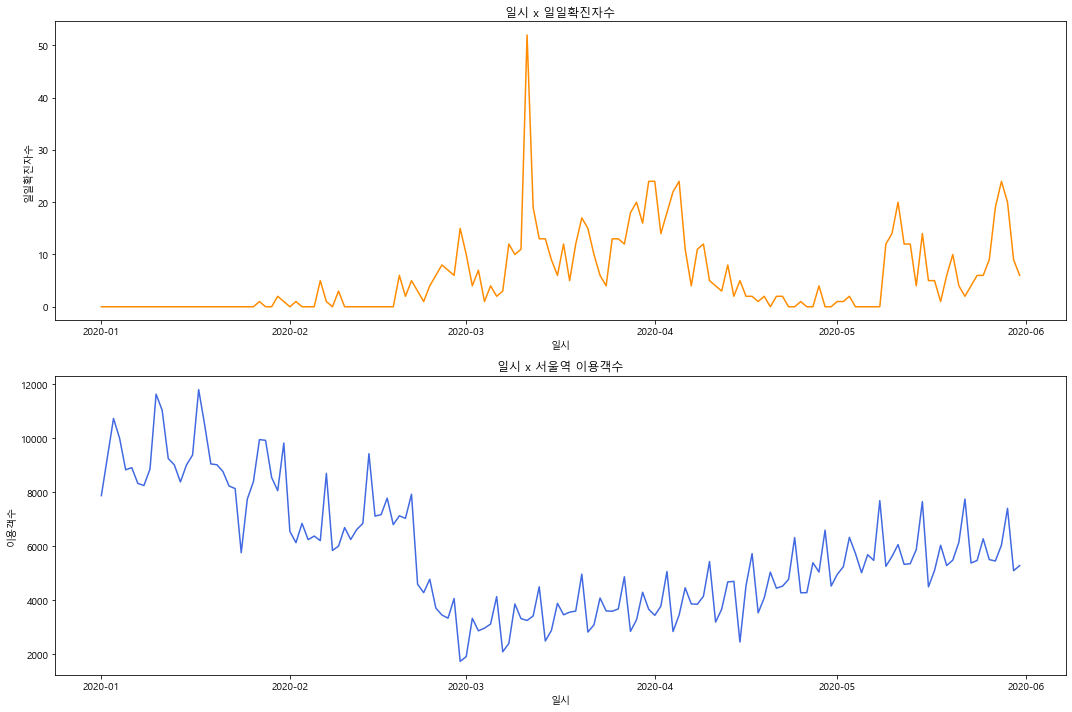

In [34]:
plt.figure(figsize=(15,10))
plt.subplot(2,1,1)
sns.lineplot(df3.index, df3, color='darkorange')
plt.title("일시 x 일일확진자수")

plt.subplot(2,1,2)
sns.lineplot(df2.index, df2, color='royalblue')
plt.title("일시 x 서울역 이용객수")

plt.tight_layout()

plt.savefig('figure.png', dpi=300)

**의견**  
* 코로나 발발 이후 서울역 이용객수는 점자 감소하는 추세를 보이다가, 3월 신천지 집단감염 (&사회적거리두기 2단계) 이후 급감했습니다.  
* 3월 최대 일일 확진자수가 나온 이후 서울에서 일일확진자수는 최대만큼은 아니지만 오르락 내리락하는 모습을 보여줍니다.  
* 그러나 서울역 이용객수는 점차 증가하는 추세를 보여줍니다.  
* 서울역을 이용하는 사람이 점차 증가함으로 인해 코로나 확산이 염려됩니다. 따라서 지하철역의 철저한 방역과 비접촉 승하차 방법 도입이 중요한 것으로 보입니다.

## 3-1. 서울역 일일 이용객수 x 서울 코로나 일일확진자수

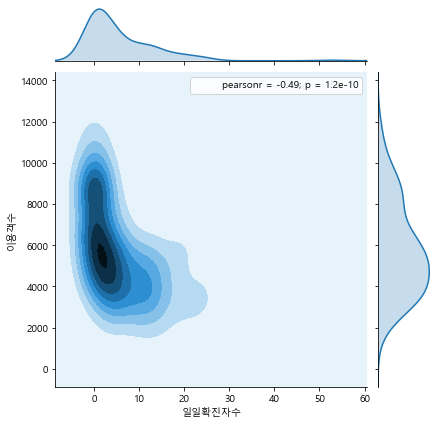

In [93]:
# 일일확진자수 x 서울역 이용객수 => 음의 상관관계 있음
fig=sns.jointplot(df3, df2, kind='kde')
fig.annotate(stats.pearsonr)

## 3-2. 서울역 일일 이용객수 x 서울 코로나 누적확진자수

In [94]:
df4 = seoul_weather_sub['확진자수'].groupby([seoul_weather_sub['일시'].dt.date]).mean()
df4

일시
2020-01-01      0.0
2020-01-02      0.0
2020-01-03      0.0
2020-01-04      0.0
2020-01-05      0.0
              ...  
2020-05-27    802.0
2020-05-28    826.0
2020-05-29    846.0
2020-05-30    855.0
2020-05-31    861.0
Name: 확진자수, Length: 152, dtype: float64

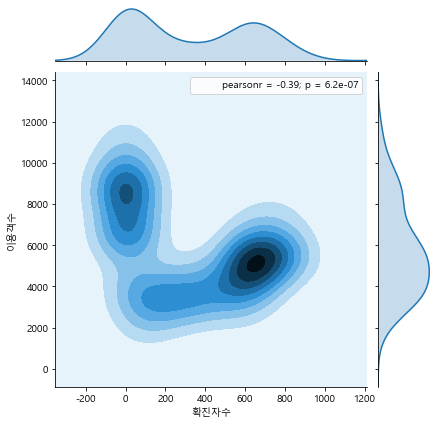

In [95]:
# 누적확진자수 x 서울역 이용객수 => 음의 상관관계 있음 & 두군데의 피크가 있음 (**집단감염 발병의 영향으로 여겨짐)
fig2 = sns.jointplot(df4, df2, kind='kde')
fig2.annotate(stats.pearsonr)
plt.show()

**의견:**
1. 코로나 일일확진자수와 누적확진자수 모두 서울역 이용객수와 음의 상관관계를 보임 -> 확진자수가 늘어날수록 서울역 이용객수가 줄어듬  
2. 일일확진자수가 누적확진자수보다 서울역 이용객수의 변화에 더 큰 영향을 주는 것으로 보임
3. 누적확진자 그래프에서 peak가 두군데 나타나는 것으로 보아 집단감염이 서울역 이용객수 감소에 영향을 주는 것으로 여겨짐

# 3. 2019,2020년 1-5월 중 이용객수가 가장많은 서울지하철역 (1~9호선) Top5 

### - 이용객수 = 총승차인원 + 총하차인원

## 3-1. 2019년도 Top5

In [35]:
df = pd.read_csv('subway/CARD_SUBWAY_MONTH_201901.csv', encoding="cp949")
df = df.drop(['사용일자','등록일자'],axis=1)
df['노선명'] = df[df['노선명'].str.contains('\d호선',regex= True)]
df.dropna(inplace=True)
df = df.groupby(['역명']).sum()

df2 = pd.read_csv('subway/CARD_SUBWAY_MONTH_201902.csv', encoding="cp949")
df2 = df2.drop(['사용일자','등록일자'],axis=1)
#정규표현식을 이용해 1~9호선만 추출
df2['노선명'] = df2[df2['노선명'].str.contains('\d호선',regex= True)]
df2.dropna(inplace=True)
df2 = df2.groupby(['역명']).sum()

df3 = pd.read_csv('subway/CARD_SUBWAY_MONTH_201903.csv', encoding="cp949")
df3 = df3.drop(['사용일자','등록일자'],axis=1)
df3['노선명'] = df3[df3['노선명'].str.contains('\d호선',regex= True)]
df3.dropna(inplace=True)
df3 = df3.groupby(['역명']).sum()

df4 = pd.read_csv('subway/CARD_SUBWAY_MONTH_201904.csv', encoding="cp949")
df4 = df4.drop(['사용일자','등록일자'],axis=1)
df4['노선명'] = df4[df4['노선명'].str.contains('\d호선',regex= True)]
df4.dropna(inplace=True)
df4 = df4.groupby(['역명']).sum()

df5 = pd.read_csv('subway/CARD_SUBWAY_MONTH_201905.csv', encoding="cp949")
df5 = df5.drop(['사용일자','등록일자'],axis=1)
df5['노선명'] = df5[df5['노선명'].str.contains('\d호선',regex= True)]
df5.dropna(inplace=True)
df5 = df5.groupby(['역명']).sum()

In [36]:
seoul_user19 =  pd.concat([df,df2,df3,df4,df5])
seoul_user19 = seoul_user19.groupby(['역명']).sum()

In [37]:
seoul_user19['총이용객수'] = seoul_user19['승차총승객수'] + seoul_user19['하차총승객수']

In [38]:
seoul19_top5 =  seoul_user19.sort_values(by=['총이용객수'], ascending=False)[:5]
seoul19_top5.drop(['승차총승객수','하차총승객수'],axis=1,inplace=True)
seoul19_top5

,총이용객수
역명,
잠실(송파구청),31067561.0
강남,30754056.0
고속터미널,29480362.0
홍대입구,29066266.0
서울역,26136295.0


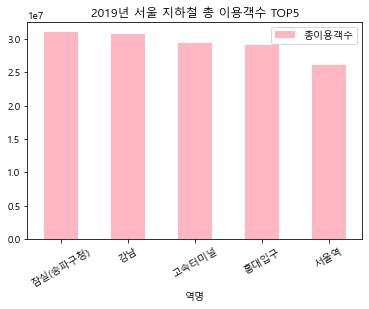

In [39]:
seoul19_top5.plot(kind='bar',color = 'lightpink')
plt.legend()
plt.xticks(rotation=30)
plt.title('2019년 서울 지하철 총 이용객수 TOP5')
plt.show()

## 3-2. 2020년도 Top5

In [40]:
#데이터 전처리
df = pd.read_csv('subway/CARD_SUBWAY_MONTH_202001.csv', encoding="cp949")
df = df.drop(['사용일자','등록일자'],axis=1)
#정규표현식을 이용해 1~9호선만 추출
df['노선명'] = df[df['노선명'].str.contains('\d호선',regex= True)]
df.dropna(inplace=True)
df = df.groupby(['역명']).sum()

df2 = pd.read_csv('subway/CARD_SUBWAY_MONTH_202002.csv', encoding="cp949")
df2 = df2.drop(['사용일자','등록일자'],axis=1)
#정규표현식을 이용해 1~9호선만 추출
df2['노선명'] = df2[df2['노선명'].str.contains('\d호선',regex= True)]
df2.dropna(inplace=True)
df2 = df2.groupby(['역명']).sum()

df3 = pd.read_csv('subway/CARD_SUBWAY_MONTH_202003.csv', encoding="cp949")
df3 = df3.drop(['사용일자','등록일자'],axis=1)
#정규표현식을 이용해 1~9호선만 추출
df3['노선명'] = df3[df3['노선명'].str.contains('\d호선',regex= True)]
df3.dropna(inplace=True)
df3 = df3.groupby(['역명']).sum()

df4 = pd.read_csv('subway/CARD_SUBWAY_MONTH_202004.csv', encoding="cp949")
df4 = df4.drop(['사용일자','등록일자'],axis=1)
df4['노선명'] = df4[df4['노선명'].str.contains('\d호선',regex= True)]
df4.dropna(inplace=True)
df4 = df4.groupby(['역명']).sum()

df5 = pd.read_csv('subway/CARD_SUBWAY_MONTH_202005.csv', encoding="utf-8",
                  names=['사용일자','노선명','역명','승차총승객수','하차총승객수','등록일자'])
df5 = df5.drop([0])
df5['노선명'] = df5[df5['노선명'].str.contains('\d호선',regex= True)]
df5.dropna(inplace=True)
df5 = df5.drop(['사용일자','등록일자','노선명'],axis=1)
df5[['승차총승객수', '하차총승객수']] =  df5[['승차총승객수', '하차총승객수']].apply(pd.to_numeric,errors = 'coerce')
df5 =  df5.groupby(['역명']).sum()

In [41]:
seoul_user20 =  pd.concat([df,df2,df3,df4,df5])
seoul_user20 = seoul_user20.groupby(['역명']).sum()

In [43]:
seoul_user20['총이용객수'] = seoul_user20['승차총승객수'] + seoul_user20['하차총승객수']

In [44]:
seoul20_top5 =  seoul_user20.sort_values(by=['총이용객수'], ascending=False)[:5]
seoul20_top5.drop(['승차총승객수','하차총승객수'],axis=1,inplace=True)
seoul20_top5

,총이용객수
역명,
강남,23025100.0
잠실(송파구청),21615845.0
고속터미널,18977358.0
홍대입구,18582810.0
서울역,16726318.0


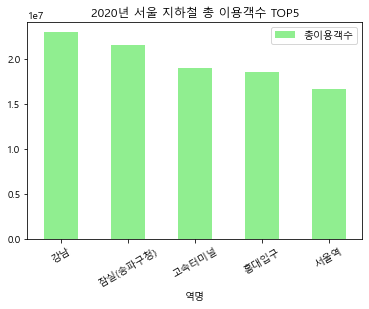

In [45]:
seoul20_top5.plot(kind='bar',color = 'lightgreen')
plt.legend()
plt.xticks(rotation=30)
plt.title('2020년 서울 지하철 총 이용객수 TOP5')
plt.show()

**의견:**
1. 19년도나 20년도에 지하철 이용수가 가장많은 역 5개는 순위는 다르지만 변함이 없음 => 코로나가 터지나 안터지나 많이 이용하는 역사라는것
2. 개찰구 하이패스를 시범 운행역으로 이 5개역을 꼽는것은 어떤가 제안

# 4. 1~9호선 데이터를 통한 지도 시각화

## 4-1. 9호선 데이터를 위한 웹 크롤링 및 데이터 전처리

In [54]:
driver = webdriver.Chrome("c:/mychrome/chromedriver.exe")

In [55]:
def get_search_page_url(code):
    return 'https://www.metro9.co.kr/site/program/station/info?menuid=001001002&station_code={}'.format(code)

code=901
url = get_search_page_url(code)

In [56]:
def get_line9_items(line9_items):
    line9_data = []
    for line9_item in line9_items:
        #역명
        try:
            station_name = line9_item.select('div.table_type_h1.mt2 >table > tbody > tr > td:nth-child(1)')[0].text
        except:
            station_name =''
        #주소
        try:
            station_add = line9_item.select('div.table_type_h1.mt2 >table > tbody > tr > td:nth-child(5)')[0].text
        except:
            station_add =''
    
        line9_data.append([station_name,station_add])
    return line9_data

In [57]:
line9_data_total=[]

#진행상황 출력
for code in tqdm(range(901,939)):
    url = get_search_page_url(code)
    driver.get(url)
    time.sleep(3) # 페이지 로딩하는데 시간이 걸림
    
    #현재 페이지 html문서 가져오가
    html = driver.page_source
    soup = BeautifulSoup(html,'html.parser')
    
    line9_items =  soup.select('div.inner')
    line9_data_list = get_line9_items(line9_items)
    
    line9_data_total = line9_data_total + line9_data_list

In [58]:
# dataframe 으로 만들어주기
data = pd.DataFrame(line9_data_total)
data.columns = ['역명','상세주소']
data['호선'] = '9'
data

,역명,상세주소,호선
0,개화,서울특별시 강서구 개화동로8길 19,9
1,김포공항,서울특별시 강서구 하늘길 지하77,9
2,공항시장,서울특별시 강서구 방화동로 지하30,9
3,신방화,서울특별시 강서구 방화대로 지하301,9
4,마곡나루,서울특별시 강서구 마곡중앙5로 지하2,9
5,양천향교,서울특별시 강서구 양천로 지하341,9
6,가양,서울특별시 강서구 양천로 지하485,9
7,증미,서울특별시 강서구 양천로 지하560,9
8,등촌,서울특별시 강서구 공항대로 지하529,9
9,염창,서울특별시 강서구 공항대로 지하631,9


In [59]:
# 공공데이터 포털에서? 서울시 1~8호선 정보 읽기 
test = pd.read_excel('info.xlsx', encoding="utf-8",index=False,
                    names=['연변','역명','호선','구','동','상세주소','전화번호'])
test = test.drop([0])
test = test.drop(['연변','동','구','전화번호'],axis=1)
test.head()

,역명,호선,상세주소
1,서울,1,서울특별시 중구 봉래동2가 122 서울역(1호선)
2,시청,1,서울특별시 중구 정동 5-5 시청역(1호선)
3,종각,1,서울특별시 종로구 종로1가 54 종각지하철역사
4,종로3가,1,서울특별시 종로3가 10-5 1호선 종로3가역(1호선)
5,종로5가,1,서울특별시 종로구 종로5가 82-1 1호선 종로5가역


In [60]:
#9호선 크롤링한 데이터와 1~8호선 데이터 합치기
subway = pd.concat([data,test])
subway

,역명,상세주소,호선
0,개화,서울특별시 강서구 개화동로8길 19,9
1,김포공항,서울특별시 강서구 하늘길 지하77,9
2,공항시장,서울특별시 강서구 방화동로 지하30,9
3,신방화,서울특별시 강서구 방화대로 지하301,9
4,마곡나루,서울특별시 강서구 마곡중앙5로 지하2,9
...,...,...,...
274,남한산성입구(성남법원•검찰청),경기도 성남시 수정구 단대동 96 남한산성입구역,8
275,단대오거리,경기도 성남시 수정구 신흥동 2467 단대오거리역,8
276,신흥,경기도 성남시 수정구 신흥동 2467 신흥역,8
277,수진,경기도 성남시 수정구 수진동 2205-1 수진역,8


In [ ]:
# Geocode by Awesome Table 를 이용해 도로명 주소 위경도를 받기 위해 excel파일로 빼주기

In [ ]:
subway.to_excel('subway.xlsx')

In [61]:
# 위경도 추가 된 파일 불러오기
subway_seoul = pd.read_csv('subway_seoul.csv', encoding="utf-8")
subway_seoul = subway_seoul.drop(['Unnamed: 0','호선'],axis=1)
subway_seoul

,역명,상세주소,Latitude,Longitude
0,개화,서울특별시 강서구 개화동로8길 19,37.578990,126.801260
1,김포공항,서울특별시 강서구 하늘길 지하77,37.560320,126.798234
2,공항시장,서울특별시 강서구 방화동로 지하30,37.566506,126.811273
3,신방화,서울특별시 강서구 방화대로 지하301,37.566975,126.816813
4,마곡나루,서울특별시 강서구 마곡중앙5로 지하2,37.570165,126.826482
...,...,...,...,...
311,남한산성입구(성남법원•검찰청),경기도 성남시 수정구 단대동 96 남한산성입구역,37.451532,127.159789
312,단대오거리,경기도 성남시 수정구 신흥동 2467 단대오거리역,37.440749,127.146349
313,신흥,경기도 성남시 수정구 신흥동 2467 신흥역,37.440749,127.146349
314,수진,경기도 성남시 수정구 수진동 2205-1 수진역,37.437776,127.140430


In [62]:
# 서울 지하철 노선(네이버 크롤링) 한 파일 불러오기
subway_seoul_fin = pd.read_csv('subway_seoul_fin.csv', encoding="utf-8")
subway_seoul_fin.dropna(inplace=True)
subway_seoul_fin[subway_seoul_fin['호선'].str.contains('\d호선',regex= True)]

,역명,호선
0,홍대입구역,2호선
1,성신여대입구역,4호선
2,잠실역,2호선
3,서울대입구역,2호선
4,신논현역,9호선
...,...,...
295,남구로역,7호선
296,마포구청역,6호선
297,동작역,4호선
298,돌곶이역,6호선


In [63]:
# 역 이름 맞춰주기
subway_seoul_fin['역명'] = subway_seoul_fin['역명'].apply(lambda x: x.replace('역',''))

In [64]:
seoul_subway = pd.merge(subway_seoul,subway_seoul_fin, how='outer',on='역명')
seoul_subway = seoul_subway.dropna(axis=0)

In [65]:
# 호선 수 제거하고  int로 형변환
seoul_subway['호선'] = seoul_subway['호선'].apply(lambda x: x.replace('호선',''))
seoul_subway['호선'] = seoul_subway['호선'] .apply(pd.to_numeric,errors = 'coerce')

In [66]:
seoul_subway= seoul_subway.dropna(axis=0)

In [67]:
seoul_subway.head()

,역명,상세주소,Latitude,Longitude,호선
0,개화,서울특별시 강서구 개화동로8길 19,37.578990,126.801260,9.0
1,김포공항,서울특별시 강서구 하늘길 지하77,37.560320,126.798234,9.0
3,김포공항,서울특별시 강서구 방화동 886 김포공항역,37.566773,126.802512,9.0
5,공항시장,서울특별시 강서구 방화동로 지하30,37.566506,126.811273,9.0
6,신방화,서울특별시 강서구 방화대로 지하301,37.566975,126.816813,9.0


## 4-2. 서울시 지하철 노선도 지도시각화
- 이용객수에 따른 수치 시각화

In [68]:
# 이용객수 + 지하철 위경도 파일 합치기
seoul_subway= pd.merge(seoul_subway,seoul_user20,how='outer',on='역명')
seoul_subway.dropna(inplace=True)
seoul_subway.head()

,역명,상세주소,Latitude,Longitude,호선,승차총승객수,하차총승객수,총이용객수
0,개화,서울특별시 강서구 개화동로8길 19,37.578990,126.801260,9.0,311758.0,225574.0,537332.0
1,김포공항,서울특별시 강서구 하늘길 지하77,37.560320,126.798234,9.0,2911204.0,2707711.0,5618915.0
2,김포공항,서울특별시 강서구 방화동 886 김포공항역,37.566773,126.802512,9.0,2911204.0,2707711.0,5618915.0
3,공항시장,서울특별시 강서구 방화동로 지하30,37.566506,126.811273,9.0,361890.0,399900.0,761790.0
4,신방화,서울특별시 강서구 방화대로 지하301,37.566975,126.816813,9.0,828706.0,805233.0,1633939.0


In [69]:
# 총이용객수 정규화
max(seoul_subway['총이용객수']) - min(seoul_subway['총이용객수'])
mean_people = seoul_subway.총이용객수.mean()
max_people  = seoul_subway.총이용객수.max()
min_people = seoul_subway.총이용객수.min()

seoul_subway['총이용객수']= seoul_subway['총이용객수'].apply(lambda x: (x - mean_people ) / (max_people -min_people ))

In [70]:
line1=seoul_subway[seoul_subway['호선']==1]
line2=seoul_subway[seoul_subway['호선']==2]
line3=seoul_subway[seoul_subway['호선']==3]
line4=seoul_subway[seoul_subway['호선']==4]
line5=seoul_subway[seoul_subway['호선']==5]
line6=seoul_subway[seoul_subway['호선']==6]
line7=seoul_subway[seoul_subway['호선']==7]
line8=seoul_subway[seoul_subway['호선']==8]
line9=seoul_subway[seoul_subway['호선']==9]

In [75]:
stations = folium.Map(
location=[37.573050, 126.979189],#서울 중심부의 위치
    tiles='Stamen Toner',
    zoom_start = 10
)

#### stations #####################################################
for idx in line1.index:
    lat=seoul_subway.loc[idx, 'Latitude'] 
    lng=seoul_subway.loc[idx, 'Longitude']    
    r = seoul_subway.loc[idx,'총이용객수']
    fillColor = 'blue'
    folium.CircleMarker(
        location=[lat,lng],
        color="blue", #yellow
        fill_color=fillColor,
        radius=r*50, 
        fill_opacity=0.5,
        weight=1.5,
    ).add_to(stations)
    
for idx in line2.index:
    lat=seoul_subway.loc[idx, 'Latitude'] 
    lng=seoul_subway.loc[idx, 'Longitude']
    r = seoul_subway.loc[idx,'총이용객수']
    fillColor = 'lightgreen'
    folium.CircleMarker(
        location=[lat,lng],
        color="lightgreen", #yellow
        fill_color=fillColor,
        radius=r*50, 
        fill_opacity=0.5,
        weight=1.5
    ).add_to(stations)

for idx in line3.index:
    lat=seoul_subway.loc[idx, 'Latitude'] 
    lng=seoul_subway.loc[idx, 'Longitude']
    r = seoul_subway.loc[idx,'총이용객수']
    fillColor = 'orange'
    folium.CircleMarker(
        location=[lat,lng],
        color="orange", #yellow
        fill_color=fillColor,
        radius=r*50,
        fill_opacity=0.5,
        weight=1.5
    ).add_to(stations)
for idx in line4.index:
    lat=seoul_subway.loc[idx, 'Latitude'] 
    lng=seoul_subway.loc[idx, 'Longitude']
    r = seoul_subway.loc[idx,'총이용객수']
    fillColor = 'lightblue'
    folium.CircleMarker(
        location=[lat,lng],
        color="lightblue", #yellow
        fill_color=fillColor,
        radius=r*50,
        fill_opacity=0.5,
        weight=1.5
    ).add_to(stations)
for idx in line5.index:
    lat=seoul_subway.loc[idx, 'Latitude'] 
    lng=seoul_subway.loc[idx, 'Longitude']
    r = seoul_subway.loc[idx,'총이용객수']
    fillColor = 'purple'
    folium.CircleMarker(
        location=[lat,lng],
        color="purple", #yellow
        fill_color=fillColor,
        radius=r*50,
        weight=1.5
    ).add_to(stations)
for idx in line6.index:
    lat=seoul_subway.loc[idx, 'Latitude'] 
    lng=seoul_subway.loc[idx, 'Longitude']
    r = seoul_subway.loc[idx,'총이용객수']
    fillColor = 'darkred'
    folium.CircleMarker(
        location=[lat,lng],
        color="darkred", #yellow
        fill_color=fillColor,
        radius=r*50,
        fill_opacity=0.5,
        weight=1.5
    ).add_to(stations)
for idx in line7.index:
    lat=seoul_subway.loc[idx, 'Latitude'] 
    lng=seoul_subway.loc[idx, 'Longitude']
    r = seoul_subway.loc[idx,'총이용객수']
    fillColor = 'darkgreen'
    folium.CircleMarker(
        location=[lat,lng],
        color="darkgreen", #yellow
        fill_color=fillColor,
        radius=r*50,
        fill_opacity=0.5,
        weight=1.5
    ).add_to(stations)
for idx in line8.index:
    lat=seoul_subway.loc[idx, 'Latitude'] 
    lng=seoul_subway.loc[idx, 'Longitude']
    r = seoul_subway.loc[idx,'총이용객수']
    fillColor = 'pink'
    folium.CircleMarker(
        location=[lat,lng],
        color="pink", 
        fill_color=fillColor,
        radius=r*50,
        fill_opacity=0.5,
        weight=1.5
    ).add_to(stations)
for idx in line9.index:
    lat=seoul_subway.loc[idx, 'Latitude'] 
    lng=seoul_subway.loc[idx, 'Longitude']
    r = seoul_subway.loc[idx,'총이용객수']
    fillColor = "brown"
    folium.CircleMarker(
        location=[lat,lng],
        color="black", 
        fill_color=fillColor,
        radius=r*50, 
        fill_opacity=0.5,
        weight=1.5
    ).add_to(stations)
    stations.save('map1.html') #파일이 저장될 위치
stations

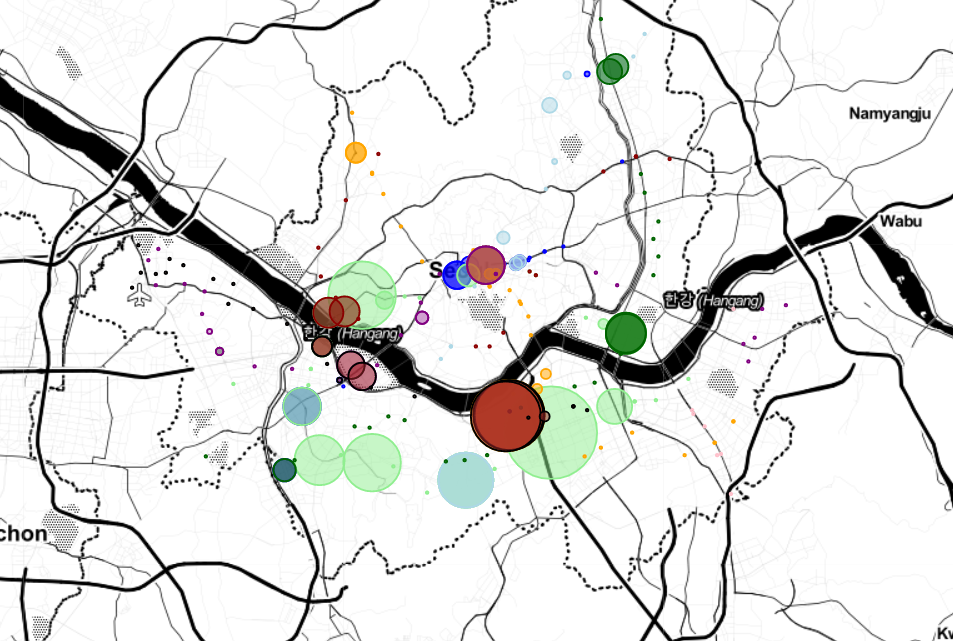

In [76]:
# 지도가 잘 안나올 경우를 대비하여
maps = pilimg.open('map.png')
maps

# 5. 예측모델(RandomForest, LSTM)

## 5-1. RandomForest

## 5-1-1. RandomForest란?
- 랜덤성을 가진 다수의 의사결정 Tree를 결합하여 하나의 모형을 생성하는 방법
- 결과적으로 여러가지 입력 변수를 다루는데 편리함
- 장, 단점
    - 장점
        - 높은 정확성
        - 변수 소거 없이 수천 개의 입력 변수들을 다루는 것이 가능
        - 회귀 및 분류작업 가능
    - 단점
        - 굉장히 많은 메모리 사용량
        - Training data의 양이 증가해도 급격한 성능 향상은 없음

## 5-1-2. RandomForest 활용 목표
- 수집한 데이터 중 서울 지하철 이용객수와 연관성 있는 피처 도출 <br>
피처값: 온도,습도,강수량,적설,일일확진자 or 누적확진자, 기간별 index

## 사회적거리두기 index
- 사회적거리두기 : 3월 22일 ~ 5월 5일  : 2
- 아무것도 안했을 경우 : 신천지 터지기 전, 5월 5일 이후 : 1
- 코로나 터지기 전 1월 19일까지: 0

In [136]:
# index만들기 위한 전처리 과정
index_0 = seoul_weather_sub['일시'].loc[seoul_weather_sub["일시"].between('2020-01-01 00:00:00','2020-01-19 23:00:00')]
a = seoul_weather_sub['일시'].loc[seoul_weather_sub["일시"].between('2020-01-20 00:00:00','2020-03-21 23:00:00')]
b =  seoul_weather_sub['일시'].loc[seoul_weather_sub["일시"].between('2020-05-06 00:00:00','2020-05-31 23:00:00')]
index_1 = pd.concat([a,b],axis=0)
index_2 = seoul_weather_sub['일시'].loc[seoul_weather_sub["일시"].between('2020-03-22 00:00:00','2020-05-05 23:00:00')]

In [137]:
df = pd.DataFrame({'일시':index_0, 'index':0})
df2 = pd.DataFrame({'일시':index_1, 'index':1})
df3 = pd.DataFrame({'일시':index_2, 'index':2})

In [138]:
index = pd.concat([df,df2,df3],axis=0) 

In [142]:
seoul = pd.merge(seoul_weather_sub,index, how='outer',on='일시')

In [169]:
seoul.rename(columns={'기온(°C)': '기온',
                  '강수량(mm)': '강수량',
                  '습도(%)': '습도',
                  '적설(cm)': '적설'},
         inplace=True)
seoul = seoul.fillna(0)
seoul.head()

,이용객수,일시,요일,년도,확진자수,퇴원자수,지역,지점,지점명,기온,강수량,습도,적설,일일확진자수,index
0,17,2020-01-01,2,2020,0.0,0.0,Seoul,108,서울,-6.5,0.0,38,0.0,0,0
1,17,2020-01-01,2,2020,0.0,0.0,Seoul,108,서울,-6.5,0.0,38,0.0,0,0
2,17,2020-01-01,2,2020,0.0,0.0,Seoul,108,서울,-6.5,0.0,38,0.0,0,0
3,17,2020-01-01,2,2020,0.0,0.0,Seoul,108,서울,-6.5,0.0,38,0.0,0,0
4,17,2020-01-01,2,2020,0.0,0.0,Seoul,108,서울,-6.5,0.0,38,0.0,0,0


### 누적확진자일경우

In [170]:
# feature와 타겟데이터 가공
train_features = seoul[['확진자수','기온','강수량','습도','적설','index']]
train_targets = seoul['이용객수']

In [171]:
X_train, X_test, y_train, y_test = train_test_split(train_features, train_targets, random_state=0)

In [186]:
# 학습 진행 트리 100개로 진행
rf_clf = RandomForestClassifier(n_estimators=100,random_state=0)
rf_clf.fit(X_train, y_train)
# 예측
y_pred=rf_clf.predict(X_test)

In [187]:
print("총테스트 개수 %d, 오류개수: %d" %(len(y_test),(y_test != y_pred).sum()))
print("정확도:",metrics.accuracy_score(y_test, y_pred))

총테스트 개수 15922, 오류개수: 405
정확도: 0.9745634970481095


### 중요 feature 찾기

In [188]:
feature_imp = pd.Series(clf.feature_importances_,index=['확진자수','기온','강수량','습도','적설','index']).sort_values(ascending=False)
feature_imp

기온       0.447969
습도       0.340495
확진자수     0.172874
강수량      0.018921
index    0.010824
적설       0.008917
dtype: float64

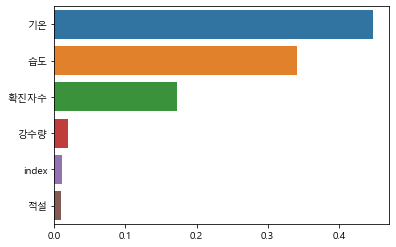

In [189]:
sns.barplot(x=feature_imp, y=feature_imp.index)
plt.show()

### 일일 확진자일 경우

In [177]:
train_features = seoul[['일일확진자수','기온','강수량','습도','적설']]
train_targets = seoul['이용객수']

In [178]:
X_train, X_test, y_train, y_test = train_test_split(train_features, train_targets, random_state=0)

In [179]:
# 학습 진행 트리 100개로 진행
rf_clf = RandomForestClassifier(n_estimators=100,random_state=0)
rf_clf.fit(X_train, y_train)
# 예측
y_pred=rf_clf.predict(X_test)

In [184]:
print("총테스트 개수 %d, 오류개수: %d" %(len(y_test),(y_test != y_pred).sum()))
print("정확도:",metrics.accuracy_score(y_test, y_pred))

총테스트 개수 15922, 오류개수: 402
정확도: 0.974751915588494


In [190]:
# 각 피쳐의 중요도
feature_imp = pd.Series(rf_clf.feature_importances_,index=['일일확진자수','기온','강수량','습도','적설']).sort_values(ascending=False)
feature_imp

기온        0.510704
습도        0.335916
일일확진자수    0.124863
강수량       0.018794
적설        0.009722
dtype: float64

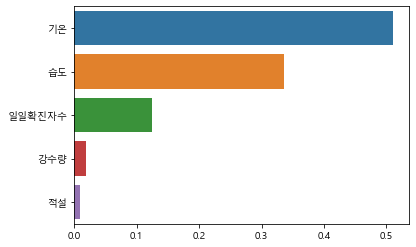

In [191]:
sns.barplot(x=feature_imp, y=feature_imp.index)
plt.show()

### 일일확진자 + index2일경우(사회적거리두기를 했을 경우)

In [192]:
index2 =  seoul[seoul['index']==2]

In [193]:
train_features = index2[['일일확진자수','기온','강수량','습도','적설']]
train_targets = index2['이용객수']

In [194]:
X_train, X_test, y_train, y_test = train_test_split(train_features, train_targets, random_state=0)

In [195]:
# 학습 진행 트리 100개로 진행
rf_clf = RandomForestClassifier(n_estimators=100,random_state=0)
rf_clf.fit(X_train, y_train)
# 예측
y_pred=rf_clf.predict(X_test)

In [196]:
print("총테스트 개수 %d, 오류개수: %d" %(len(y_test),(y_test != y_pred).sum()))
print("정확도:",metrics.accuracy_score(y_test, y_pred))

총테스트 개수 4603, 오류개수: 41
정확도: 0.9910927655876602


In [198]:
# 각 피쳐의 중요도
feature_imp = pd.Series(rf_clf.feature_importances_,index=['일일확진자수','기온','강수량','습도','적설']).sort_values(ascending=False)
feature_imp

기온        0.463528
습도        0.373607
일일확진자수    0.151074
강수량       0.011792
적설        0.000000
dtype: float64

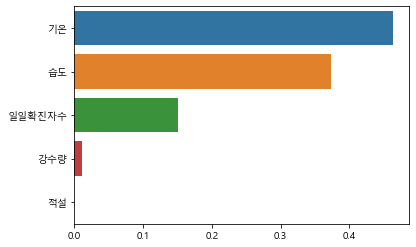

In [199]:
sns.barplot(x=feature_imp, y=feature_imp.index)
plt.show()

**의견**  
* 코로나 이후 확진자 수와 관련이있을 줄 알았으나 기온이라는 점을 알게 되었습니다.
* 강수량도 중요한 요인이 되고있습니다.
* 확진자가 늘더라도 이용객들은 크게영향을 받지않고 지하철을 이용한다는 것을 알게 되었습니다. 그러므로 많이 이용하는 역은 선제 방역이 필요할 것으로 보입니다.


## 5-2. LSTM

## 5-2-1. LSTM이란?
- 딥러닝 분야에서 사용되는 대표적인 인공반복신경망(RNN) 프레임워크
- 시계열 데이터를 기반으로 분류, 처리 및 예측하는데 적합
- 장, 단점
    - 장점
        - 과거(Long-term) 정보를 학습하여 미래 데이터 예측하는데 강력한 기능
        - 메모리와 결과값 컨트롤이 가능
        
    - 단점
        - 훈련하는데 많은 시간이 소요될 수 있음
        - 과적합(Overfitting) 하기 쉬움

## 5-2-2. LSTM 활용 목표
- RandomForest를 통해 얻은 유의미한 Feature를 통해 지하철역 이용객 수 예측<br>
피처값: 총 확진자, 일일 확진자, 퇴원자, 기온, 강수량, 습도, 적설량, 기간별 index

#### Y-data 추출

- 이용객수 예측을 위한 Y축 추출

In [14]:
df=pd.read_csv('seoul_subway_weather_corona+daily_v2.csv')
df=df.drop(columns=['Unnamed: 0','년도'])
df=df.set_index('일시')

In [15]:
User=df['이용객수']
User

일시
2020-01-01 00:00:00     17
2020-01-01 05:00:00     14
2020-01-01 06:00:00     64
2020-01-01 07:00:00    102
2020-01-01 08:00:00    174
                      ... 
2020-05-31 19:00:00    468
2020-05-31 20:00:00    439
2020-05-31 21:00:00    537
2020-05-31 22:00:00    396
2020-05-31 23:00:00    139
Name: 이용객수, Length: 3110, dtype: int64

#### X-data features

In [16]:
cdf=df.copy()
cdf.drop(['이용객수'], axis=1, inplace=True)

In [17]:
cdf.fillna(0)
cdf.head()

,요일,확진자수,기온,강수량,습도,적설,일일확진자수
일시,,,,,,,
2020-01-01 00:00:00,2,0,-6.5,0.0,38,0,0
2020-01-01 05:00:00,2,0,-5.2,0.0,55,0,0
2020-01-01 06:00:00,2,0,-4.8,0.0,58,0,0
2020-01-01 07:00:00,2,0,-4.6,0.0,62,0,0
2020-01-01 08:00:00,2,0,-4.6,0.0,64,0,0


## LSTM 모델 전처리

In [18]:
# 하루 24시중 00~23시의 행이 총 21번으로 나뉘어서 n번 운행 함으로 윈도우 사이즈는 21로 설정함.
window_size = 21
X = []
Y = []

for i in range(len(cdf)-window_size):
    X.append([cdf.iloc[i+j] for j in range(window_size)])
    Y.append(User[window_size+i])

In [19]:
X = np.asarray(X)
Y = np.asarray(Y)

In [20]:
print(X.shape)
print(Y.shape)

(3089, 21, 7)
(3089,)


In [23]:
# 총 길이 3089중 3000을 트레이닝으로 89를 예측 및 테스트 길이로 잡았습니다.
train_test_split = 3000
X_train = X[:train_test_split,:]
Y_train = Y[:train_test_split]

X_test = X[train_test_split:,:]
Y_test = Y[train_test_split:]

In [24]:
print(Y_train.shape)
print(X_train.shape)
print(Y_test.shape)
print(X_test.shape)

(3000,)
(3000, 21, 7)
(89,)
(89, 21, 7)


In [25]:
model = Sequential()
model.add(LSTM(200, return_sequences=True, input_shape=(21, 7,)))
model.add(LSTM(400, return_sequences=False))
model.add(Dense(1, activation='linear'))
model.compile(loss='mse', optimizer='rmsprop', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 21, 200)           166400    
_________________________________________________________________
lstm_3 (LSTM)                (None, 400)               961600    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 401       
Total params: 1,128,401
Trainable params: 1,128,401
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# 200+2+
hist = model.fit(X_train, Y_train, epochs=200, batch_size=21,validation_data=(X_test, Y_test), shuffle=True, verbose=1)  #60+200

In [ ]:
# 5. 모델 학습 과정 표시하기
fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')

acc_ax.plot(hist.history['accuracy'], 'b', label='train acc')
acc_ax.plot(hist.history['val_accuracy'], 'g', label='val acc')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

In [ ]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

In [ ]:
#plotly
split_pt = train_test_split + window_size
np.arange(window_size, split_pt, 1), train_predict
np.arange(split_pt, split_pt+len(test_predict),1), test_predict
trace = go.Scatter(x=np.arange(window_size, split_pt, 1), y=train_predict.reshape(3000), mode='lines', name='train')
trace2 = go.Scatter(x=np.arange(split_pt, split_pt+len(test_predict),1), y=test_predict.reshape(89), mode='lines', name='test')
trace3= go.Scatter(x=np.arange(1, len(User), 1), y=User, mode='lines', name='Original')

data = [trace, trace2, trace3]
py.offline.plot(data)

In [ ]:
#예측 모델 저장
model.save("model.h5")

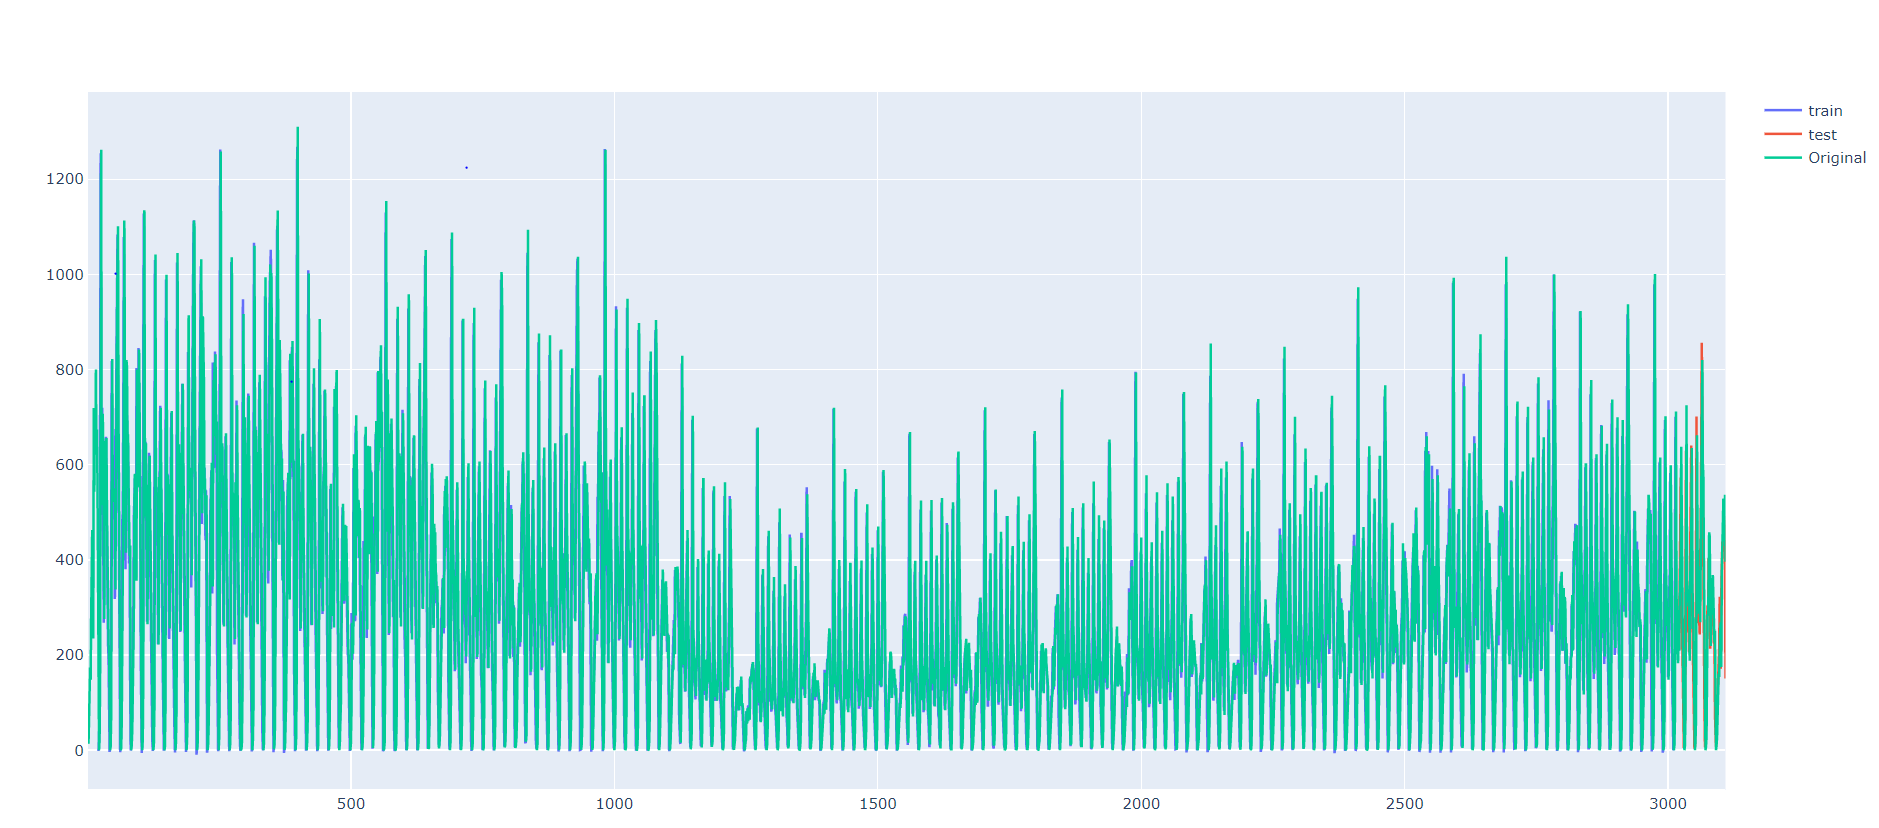

In [4]:
# 결과물
a = pilimg.open('plot.png')
a

## 나가며
2020년 9월 4일 현재, 아직도 코로나바이러스 사태는 종식되지 않았습니다. 5월 이후 안정세로 들어선줄 알았으나 8월에 발생한 여러 집단감염 사례들에 의해 다시 강도 높은 사회적 거리두기가 시작되었습니다. 코로나바이러스는 우리의 일상을 송두리채 바꿨으며 우리는 새로운 일상에 적응하기 위해 노력하고 있습니다. "이동"은 우리의 일상을 유지하는데에 중요한 부분을 차지합니다. 학교와 직장에 다니기 위해, 아끼고 사랑하는 사람들을 만나기 위해 우리는 이동합니다. 따라서 소중한 일상을 지키려면 안전한 이동이 필수입니다. <br>
<br>
이 프로젝트에서 우리는 서울시에서 사람들이 가장 많이 오고 가는 지하철역들을 살펴보았습니다. 그리고 더 나아가 코로나바이러스 사태가 1) 해당 지하철역 이용객수에 어떤 영향을 미치는지 분석하고, 2) 딥러닝을 활용하여 지하철역 이용객수가 시간대별로 어떻게 변화할지 예측하는 모델을 구축했습니다. 분석 결과, 코로나바이러스로 인한 이용객수 저하는 시간이 지날 수록 점차 증가하는 모습을 발견했습니다. 또한 구축한 모델은 시간대별 이용객수 패턴이 코로나바이러스 사태 이전과 동일하게 붐비는 시간대와 그렇지 않은 시간대가 있다는 것을 예측했으며, 이는 실제 이용객수 데이터와 매우 비슷했습니다. 이 결과는 우리에게 2가지 중요한 시사점을 알려준다고 생각합니다. <br>
   1. 코로나 확진자수와 관계없이 점차 증가하는 이용객수는 국민들의 일상으로의 회귀 욕구를 보여주는 것으로 보입니다. 
   2. 강도 높은 사회적거리두기를 COVID-19가 완전히 종식할때까지 유지하기는 어려울 것이며, 오랫기간 지속시 효과가 적어질 우려가 있습니다.

<br>
지난 8개월여간의 기간동안 우리는 제한된 공간에 많은 사람이 밀집할 수록 코로나바이러스 전파와 감염 가능성이 올라간다는 것을 배웠습니다. 가장 분주한 역을 우선으로 방역을 실시하고, 비대면 승하차 시스템을 도입한다면 이동 중에 발생하는 코로나바이러스 전파와 감염을 최소화할 수 있을 것이며, 더불어 우리의 새로운 일상을 지킬 수 있으리라 생각합니다.

'본 저작물의 저작권은 Apache License v2.0을 따릅니다'